# Example NEURON

Example utilizing the `LFPykit` module for predictions of
current dipole moment from a dendritic stick model set up in NEURON.
The passive stick receives sinusoid synaptic current input at its terminal
segment.

In [1]:
%matplotlib inline

In [2]:
# compile sinsyn.mod file using nrnivmodl script
!nrnivmodl

/Users/ehagen/Repositories/LFPykit/example
sinsyn.mod
sinsyn.mod
"/Users/ehagen/anaconda3/envs/forwardmodels/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/Users/ehagen/anaconda3/envs/forwardmodels/include/nrn" -I"/Users/ehagen/anaconda3/envs/forwardmodels/lib"    -D_FORTIFY_SOURCE=2 -mmacosx-version-min=10.9 -isystem /Users/ehagen/anaconda3/envs/forwardmodels/include  -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -isystem /Users/ehagen/anaconda3/envs/forwardmodels/include -fdebug-prefix-map=/usr/local/miniconda/conda-bld/neuron_1579771171236/work=/usr/local/src/conda/neuron-7.7.2 -fdebug-prefix-map=/Users/ehagen/anaconda3/envs/forwardmodels=/usr/local/src/conda-prefix -c -o mod_func.lo mod_func.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/Users/ehagen/anaconda3/envs/forwardmodels/include/nrn -I/Users/ehagen/anaconda3/envs/forwardmodels/lib -D_FORTIFY_SOURCE=2 -mmacosx-version-min=10.9 -isys

In [3]:
# import modules
import numpy as np
import neuron
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [4]:
class NeuronCell(lfpykit.CellGeometry, neuron.nrn.Section):
    '''
    Cell like object subclassed from CellGeometry and neuron.nrn.Section
    representing a dendritic stick with all passive parameters.
    '''
    def __init__(self):
        # initialize Section
        neuron.nrn.Section.__init__(self, name='cell')

        # specify geometry [um]
        neuron.h.pt3dadd(neuron.h.Vector([0, 0]),    # x
                         neuron.h.Vector([0, 0]),    # y
                         neuron.h.Vector([0, 200]),  # z
                         neuron.h.Vector([2, 2]),    # diam
                         sec=self)

        # passive parameters and spatial discretization
        self.cm = 1.        # membrane capacitance [uF/cm2]
        self.Ra = 1000.     # cytoplasmic resistivity [ohm cm]
        self.nseg = 41      # number of segments
        self.insert('pas')  # insert passive mechanism
        for seg in self:
            seg.pas.g = 0.0001  # passive resistivity [S/cm2]
            seg.pas.e = -65     # leak reversal potential [mV]

        # collect geometry data for each segment
        x, y, z, d = self.collect_geometry()

        # initialize  parent class CellGeometry
        lfpykit.CellGeometry.__init__(self, x, y, z, d)

        # stimuli container (synapses, point processes etc.)
        self.synapses = []

    def collect_geometry(self):
        '''
        Fetch segment geometries

        Returns
        -------
        x, y, z: ndarray
            shape (n_seg, 2) arrays with segment start and end point [um]
        d: ndarray
            shape (n_seg) ndarray with segment diameters [um]
        '''
        n3d = int(neuron.h.n3d(sec=self))
        xyzL = np.zeros((n3d, 4))
        for i in range(n3d):
            for j, fun in enumerate([neuron.h.x3d,
                                     neuron.h.y3d,
                                     neuron.h.z3d,
                                     neuron.h.arc3d]):
                xyzL[i, j] = fun(i)

        # normalize length to [0, 1]
        xyzL[:, -1] = xyzL[:, -1] / self.L

        # relative segment midpoints
        segx = np.zeros(self.nseg)
        for i, seg in enumerate(self):
            segx[i] = seg.x

        # can't be <0 which may happen due to NEURON->Python float comm.:
        gsen2 = 1 / 2 / self.nseg
        segx0 = (segx - gsen2).round(decimals=9)
        segx1 = (segx + gsen2).round(decimals=9)

        # parameters for CellGeometry
        x = np.empty((self.nseg, 2))
        y = np.empty_like(x)
        z = np.empty_like(y)
        d = np.empty(self.nseg)

        # interpolated coordinates of start and end points
        x[:, 0] = np.interp(segx0, xyzL[:, 3], xyzL[:, 0])
        x[:, 1] = np.interp(segx1, xyzL[:, 3], xyzL[:, 0])

        y[:, 0] = np.interp(segx0, xyzL[:, 3], xyzL[:, 1])
        y[:, 1] = np.interp(segx1, xyzL[:, 3], xyzL[:, 1])

        z[:, 0] = np.interp(segx0, xyzL[:, 3], xyzL[:, 2])
        z[:, 1] = np.interp(segx1, xyzL[:, 3], xyzL[:, 2])

        for i, seg in enumerate(self):
            d[i] = seg.diam

        return x, y, z, d

    def create_sinsyn(self):
        '''
        Create some stimuli at center of terminating segment.
        Stick with default params in sinsyn.mod'''
        for seg in self:
            pass
        self.synapses.append(neuron.h.SinSyn(seg.x, sec=self))

    def create_time_recorder(self):
        '''record simulation time'''
        self.time = neuron.h.Vector()
        self.time.record(neuron.h._ref_t)

    def create_voltage_recorders(self):
        '''record membrane voltages'''
        self.V_m = []
        for seg in self:
            self.V_m.append(neuron.h.Vector())
            self.V_m[-1].record(seg._ref_v)

    def create_current_recorders(self):
        '''record synapse currents'''
        self.I_m = []
        for seg in self:
            self.I_m.append(neuron.h.Vector())
            self.I_m[-1].record(seg._ref_i_membrane_)

Create `Cell` instance and initialize CVode, recorders etc.:

In [5]:
cell = NeuronCell()

# variable time step method, use_fast_imem method
cvode = neuron.h.CVode()
cvode.use_fast_imem(1)
cvode.active(1)  # set to zero to use fixed

# attach stimuli, initialize recorders
cell.create_sinsyn()
cell.create_time_recorder()
cell.create_voltage_recorders()
cell.create_current_recorders()

Create forward model object and get linear response matrix:

In [6]:
cdm = lfpykit.CurrentDipoleMoment(cell=cell)
M = cdm.get_response_matrix()

Main simulation routine:

In [7]:
# neuron.h.dt = 0.1   # simulation time resolution (using variable timesteps)
tstop = 500.        # simulation duration
v_init = -65        # membrane voltage(s) at t = 0


def initialize():
    '''
    initializing function, setting the membrane voltages to v_init and
    resetting all state variables
    '''
    neuron.h.finitialize(v_init)
    cvode.re_init()  # needed with variable time steps?
    neuron.h.frecord_init()


def apply_transform(M):
    '''Compute P for the current time step
    Parameters:
    M: ndarray
        shape (3, n_seg) linear response matrix
    '''
    I_m = np.array([seg.i_membrane_ for seg in cell])  # membrane current [nA]
    return M @ I_m


def integrate(calculate_P=True, M=None):
    '''run the simulation up until the simulation duration'''
    if calculate_P:
        P = np.zeros((3, 0))
        while neuron.h.t < tstop:
            P = np.c_[P, apply_transform(M)]
            neuron.h.fadvance()
        return P
    else:
        neuron.run(tstop)
        return

In [8]:
# initialize and run simulation, compute current dipole moment each timestep
initialize()
P = integrate(calculate_P=True, M=M)

# convert time, V_m and I_m to ndarray type for plotting
cell.time = np.array(cell.time)
cell.V_m = np.array(cell.V_m)
cell.I_m = np.array(cell.I_m)

Check that output is identical to dipole moment computed using recorded membrane currents:

In [9]:
try:
    np.testing.assert_allclose(P, M @ cell.I_m)
except AssertionError as ae:
    raise ae('not so useful error message')

Plot simulation output:

In [10]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw colorbar without resizing the axes object to make room
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

Text(0.5, 0, '$t$ (ms)')

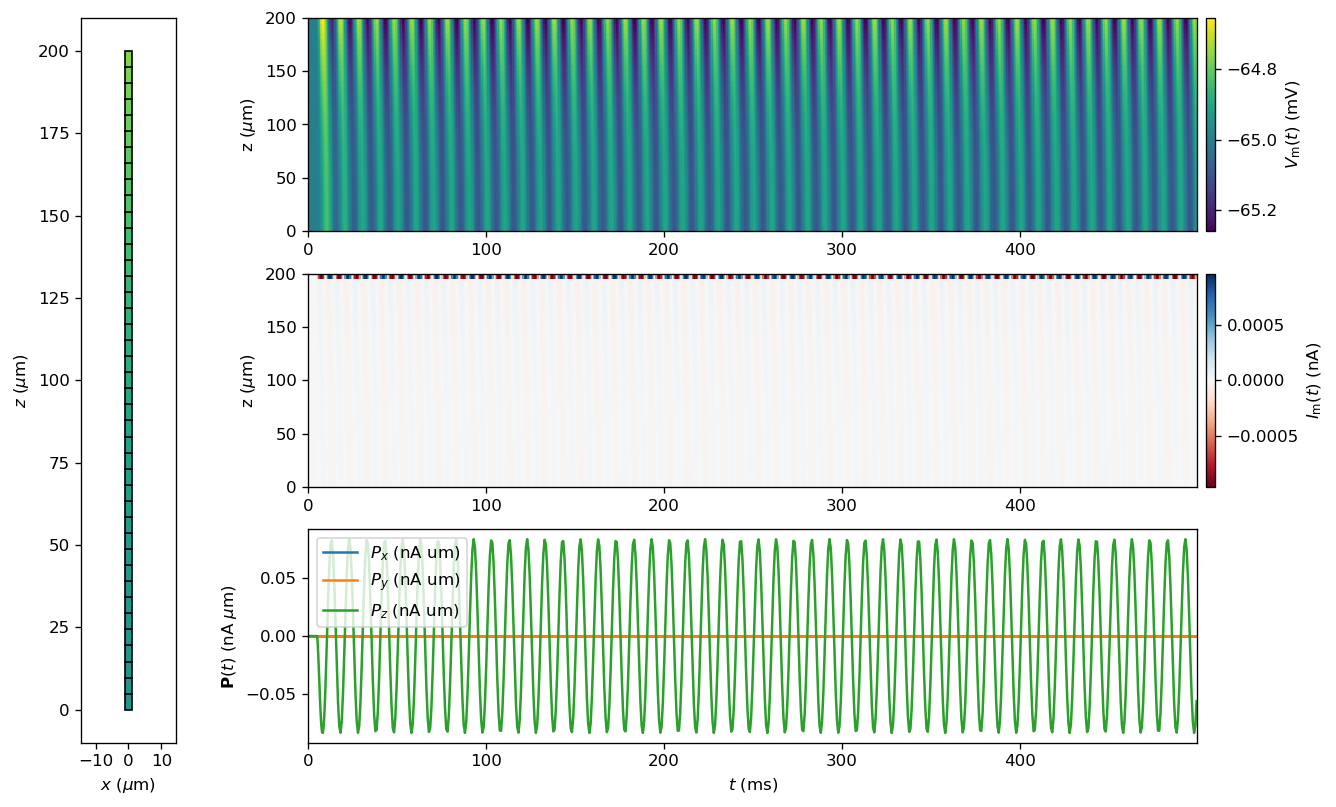

In [11]:
fig = plt.figure(figsize=(12, 8), dpi=120)
gs = GridSpec(3, 10)
# morphology
ax0 = fig.add_subplot(gs[:, 0])
norm = plt.Normalize(vmin=cell.V_m.min(), vmax=cell.V_m.max())
for z, d, v in zip(cell.z, cell.d, cell.V_m[:, -1]):
    ax0.add_patch(plt.Rectangle((-d / 2, z[0]), d, z[1] - z[0],
                                ec='k', fc=plt.cm.viridis(norm(v))))
ax0.axis(ax0.axis('equal'))
ax0.set_xlabel(r'$x$ ($\mu$m)')
ax0.set_ylabel(r'$z$ ($\mu$m)')

# membrane voltage
ax1 = fig.add_subplot(gs[0, 2:])
im1 = ax1.pcolormesh(cell.time, cell.z.mean(axis=-1), cell.V_m,
                     shading='auto', norm=norm)
ax1.set_ylabel(r'z ($\mu$m)')
cb = colorbar(fig, ax1, im1)
cb.set_label(r'$V_\mathrm{m}(t)$ (mV)')

# membrane current
ax2 = fig.add_subplot(gs[1, 2:], sharex=ax1, sharey=ax1)
im2 = ax2.pcolormesh(cell.time, cell.z.mean(axis=-1), cell.I_m,
                     cmap='RdBu', shading='auto')
ax2.set_ylabel(r'z ($\mu$m)')
cb = colorbar(fig, ax2, im2)
cb.set_label(r'$I_\mathrm{m}(t)$ (nA)')

# current dipole moment
ax3 = fig.add_subplot(gs[2, 2:], sharex=ax1)
ax3.plot(cell.time, P.T)
ax3.legend([r'$P_x$ (nA um)', r'$P_y$ (nA um)', r'$P_z$ (nA um)'])
ax3.set_ylabel(r'$\mathbf{P}(t)$ (nA $\mu$m)')
ax3.set_xlabel('$t$ (ms)')